In [224]:
import pandas as pd
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from PIL import Image
from torchvision import transforms, models

In [226]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [228]:
# Function to sample dataset and copy relevant images
import shutil

def sample_dataset_with_images(labels_csv, image_folder, output_folder, percentage=10):
    """
    Samples a percentage of the dataset and copies corresponding images to a new folder.
    """
    labels_df = pd.read_csv(labels_csv)
    assert 0 < percentage <= 100, "Percentage must be between 0 and 100"
    
    sampled_df = labels_df.sample(frac=percentage / 100, random_state=42).reset_index(drop=True)
    os.makedirs(output_folder, exist_ok=True)
    
    for image_name in sampled_df["image_name"]:
        src_path = os.path.join(image_folder, image_name)
        dest_path = os.path.join(output_folder, image_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
    
    print(f"Dataset reduced to {len(sampled_df)} samples. Images copied to {output_folder}.")
    return sampled_df

# Sample dataset
sampled_df = sample_dataset_with_images("Dataset/labels.csv", "Dataset/images/images", "Dataset/images/sampled_images/", percentage=25)
sampled_df.to_csv("sampled_labels.csv", index=False)

Dataset reduced to 1748 samples. Images copied to Dataset/images/sampled_images/.


In [230]:
# Load dataset
# labels_df = pd.read_csv("Dataset/labels.csv")
sampled_df.head(10)


,Unnamed: 0,image_name,text_ocr,text_corrected,overall_sentiment
0,4498,image_4499.jpg,I once had a Lizard and a Fish as pets..,I once had a Lizard and a Fish as pets..,positive
1,3936,image_3937.jpeg,GOES TO SCHOOL WITH 15 POGS COMES HOME WITH 100,GOES TO SCHOOL WITH 15 POGS COMES HOME WITH 100,negative
2,5059,image_5060.jpg,MERICA wo FRENCH FRY HOLDER FUCK YEAH imgflip.com,MERICA FRENCH FRY HOLDER FUCK YEAH imgflip.com,positive
3,1379,image_1380.jpg,3x02 GAANOTHSCENES You know what's weird. Dona...,3x02 GAANOTHSCENES You know what's weird. Dona...,positive
4,3870,image_3871.png,@NFL_MEMES EACH SPORT HAS IT'S GREATEST BUT HE...,@NFL_MEMES EACH SPORT HAS IT'S GREATEST BUT HE...,neutral
5,2118,image_2119.png,MY TEACHER ALWAYS SAID THAT IF YOU POINT AT SO...,MY TEACHER ALWAYS SAID THAT IF YOU POINT AT SO...,positive
6,1079,image_1080.jpg,CASH ME OUTSIDE HOW BOUT NO wake,CASH ME OUTSIDE HOW BOUT NO,positive
7,1561,image_1562.jpg,"DO YOU KNOW WHAT THE T STANDS FOR IN ""MODEL T""...","DO YOU KNOW WHAT THE T STANDS FOR IN ""MODEL T""...",neutral
8,3891,image_3892.jpg,THIS APPLE IS SO RAW THAT STEVE JOBS WAS TRYIN...,THIS APPLE IS SO RAW THAT STEVE JOBS WAS TRYIN...,negative
9,2755,image_2756.jpg,WHEN YOU FINISH AN EXAM FIRST AND WONDER WTF O...,WHEN YOU FINISH AN EXAM FIRST AND WONDER WTF O...,positive


In [231]:
# Define sentiment mapping
sentiment_map = {
    "very_negative": 0,
    "negative": 1,
    "neutral": 2,
    "positive": 3,
    "very_positive": 4
}
sampled_df["sentiment_label"] = sampled_df["overall_sentiment"].map(sentiment_map)

In [232]:
print(sampled_df["sentiment_label"].unique())  # Should be [0, 1, 2, 3, 4]


[3 1 2 4 0]


In [233]:
sampled_df = sampled_df.dropna(subset=["sentiment_label"])  # Remove NaN labels
sampled_df["sentiment_label"] = sampled_df["sentiment_label"].astype(int)  # Convert to integer


In [234]:
print(sampled_df["overall_sentiment"].unique())


['positive' 'negative' 'neutral' 'very_positive' 'very_negative']


In [241]:
print(sampled_df["text_corrected"].isna().sum())  # Count NaN values
print(sampled_df["text_corrected"].apply(type).value_counts())  # Check data types


0
text_corrected
<class 'str'>    1748
Name: count, dtype: int64


In [243]:
sampled_df["text_corrected"] = sampled_df["text_corrected"].fillna("").astype(str)


In [245]:
sample_text = sampled_df.iloc[0]["text_corrected"]
print(f"Sample text: {sample_text} (Type: {type(sample_text)})")


Sample text: I once had a Lizard and a Fish as pets.. (Type: <class 'str'>)


In [247]:
print(sampled_df["text_corrected"].isna().sum())  # Count NaN values
print(sampled_df["text_corrected"].apply(type).value_counts())  # Check data types


0
text_corrected
<class 'str'>    1748
Name: count, dtype: int64


In [249]:
# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


In [250]:
# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [253]:
# Custom dataset class
class MemeDataset(Dataset):
    def __init__(self, dataframe, image_folder, tokenizer, transform):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Text processing
        text = row["text_corrected"]
        text_encoding = self.tokenizer(
            text,
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        # Image processing
        image_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Sentiment label
        label = torch.tensor(row["sentiment_label"], dtype=torch.long)

        return {
            "input_ids": text_encoding["input_ids"].squeeze(0),
            "attention_mask": text_encoding["attention_mask"].squeeze(0),
            "image": image,
            "label": label
        }


In [255]:
dataset = MemeDataset(sampled_df, 'Dataset/images/sampled_images/', tokenizer, transform=transform)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [257]:
# Define the Multimodal Model
class MultimodalSentimentModel(nn.Module):
    def __init__(self):
        super(MultimodalSentimentModel, self).__init__()

        # RoBERTa model for text
        self.text_model = RobertaModel.from_pretrained("roberta-base")
        self.text_fc = nn.Linear(768, 256)  # Reduce dimensionality

        # ResNet model for images
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Linear(512, 256)  # Modify output layer

        # Fusion and classification layers
        self.fusion_fc = nn.Linear(512, 128)
        self.classifier = nn.Linear(128, 5)  # 5 sentiment classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = self.text_fc(text_output.pooler_output)
        text_embedding = self.relu(text_embedding)

        # Image embedding
        image_embedding = self.image_model(image)
        image_embedding = self.relu(image_embedding)

        # Fusion
        fusion = torch.cat((text_embedding, image_embedding), dim=1)
        fusion = self.fusion_fc(fusion)
        fusion = self.relu(fusion)
        fusion = self.dropout(fusion)

        # Classification
        output = self.classifier(fusion)
        return output


In [259]:
# Instantiate model and move to device
model = MultimodalSentimentModel().to(device)
print("Multimodal Model Defined!")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multimodal Model Defined!


C:\Users\Jason\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jason\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [261]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=2e-5)
optimizer = optim.Adam(model.parameters(), lr = 0.00005)


In [263]:
# Training Function
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    losses = [] 
    
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            #print(loss)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()


In [265]:
# Validation Function
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask, images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


Epoch 1, Loss: 232.9684, Train Accuracy: 0.4342
Epoch 2, Loss: 218.0859, Train Accuracy: 0.4478
Epoch 3, Loss: 181.6944, Train Accuracy: 0.5408
Epoch 4, Loss: 120.6967, Train Accuracy: 0.7525
Epoch 5, Loss: 75.4699, Train Accuracy: 0.8526
Epoch 6, Loss: 65.6796, Train Accuracy: 0.8748
Epoch 7, Loss: 51.6739, Train Accuracy: 0.9020
Epoch 8, Loss: 50.1371, Train Accuracy: 0.9056
Epoch 9, Loss: 40.9730, Train Accuracy: 0.9220
Epoch 10, Loss: 26.9488, Train Accuracy: 0.9456


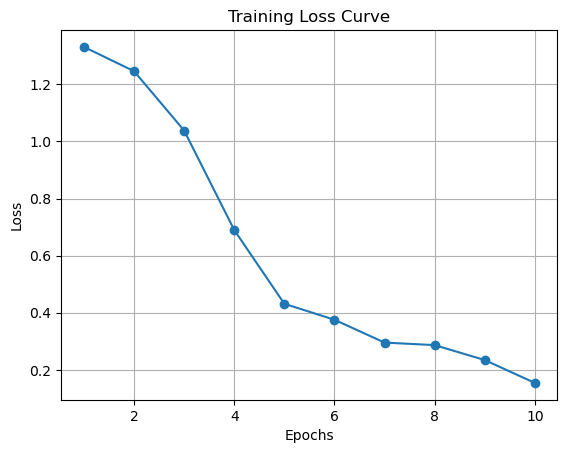

Training Complete!


In [267]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 10)
print("Training Complete!")



In [269]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask, images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect actual labels

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division = 1)

    return accuracy, precision, recall, f1


test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, val_loader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.3143
Test Precision: 0.2997
Test Recall: 0.3143
Test F1-Score: 0.3032


In [272]:
# Example single input case
def predict_single(model, text, img_path):
    model.eval()
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(encoding['input_ids'], encoding['attention_mask'], image)
        pred = torch.argmax(output, dim=1).item()
    
    print(f'Predicted Sentiment: {pred}')

In [274]:
image_path = "Dataset/images/images/image_12.jpg"
predict_single(model, "State Dining Room in the White House: 2009 vs. 2019 boredpanda.com", image_path)

Predicted Sentiment: 3
